In [26]:
import numpy as np
import pandas as pd
import networkx as nx
from itertools import combinations, product
from math import comb
import matplotlib.pyplot as plt
import sys
import warnings

warnings.filterwarnings('ignore')
print("Python version:", sys.version)
print("NetworkX version:", nx.__version__)


Python version: 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
NetworkX version: 2.7.1


### Basic definitions

For a given graph "G" and a certain node "node", we denote:

V = G.nodes

E = G.edges

n = len(V)

k = len(E(node))

# Question 1

### A

In [27]:
def get_erdos_renyi_model(n, p):
    G = nx.empty_graph(n)
    for node1, node2 in combinations(G.nodes, 2):
        if p > np.random.rand(1)[0]:
            G.add_edge(node1, node2)
    return G

### B

In [28]:
'''
k / # max links between neighbors --> k / n choose 2
'''
def get_node_clustering_coef(G, node):
    neighbors = list(nx.all_neighbors(G,node))

    # if node doesn't have neighbors then cluster coef is zero
    # ref: https://moodle.tau.ac.il/mod/forum/discuss.php?d=12728
    if G.degree(node) <= 1:
        return 0

    # get num of edges between the neighbors
    count = 0
    for e in product(neighbors, neighbors):
        if e[0] < e[1] and G.has_edge(e[0], e[1]):
            count += 1

    return count / comb(len(neighbors), 2)


In [29]:
'''
sum of the clustering coefficients of each node divided by num of nodes
'''
def get_graph_clustering_coef(G):
    result = [get_node_clustering_coef(G, node) for node in G.nodes]
    return sum(result) / G.number_of_nodes()

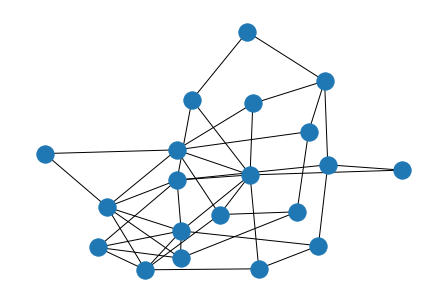

In [30]:
G = get_erdos_renyi_model(20, .2)
nx.draw(G)

In [31]:
get_graph_clustering_coef(G)

0.2038095238095238

In [32]:
def test_q1():
    """
    Some sort of unittest
    """
    ## First test case - complete graph (the clustering coef should be 1)
    G = nx.complete_graph(5)

    # single node
    res = get_node_clustering_coef(G, 0)
    if  res != 1:
        raise Exception(f"Expected 1.0 but got: {res}")
    # whole graph
    res = get_graph_clustering_coef(G)
    if  res != 1:
        raise Exception(f"Expected 1.0 but got: {res}")

    ## Second test case - random graph
    G = get_erdos_renyi_model(10, 0.5)
    # single node
    res = get_node_clustering_coef(G, 0)
    ground_truth = nx.clustering(G, 0)
    if res != ground_truth:
        raise Exception(f"Expected {ground_truth} but got: {res}")
    # whole graph
    res = get_graph_clustering_coef(G)
    ground_truth = sum(nx.clustering(G).values())/G.number_of_nodes()  # DOUBLE CHECK
    if res != ground_truth:
        raise Exception(f"Expected {ground_truth} but got: {res}")


test_q1()

# Question 2

### A

In [33]:
'''
# neighbors (:= k)
normalized: divide by n-1
'''
def get_node_degree_centrality(G, node, normalized=True):
    degree_centrality = G.degree(node) / (G.number_of_nodes()-1) if normalized else G.degree(node)
    return degree_centrality

In [34]:
'''
1 / sum of shortest paths length to all other nodes
normalized: multiply by n-1
'''
def get_node_closeness_centrality(G, node, normalized=True):
    result = [nx.shortest_path_length(G, node, curr_node) for curr_node in G.nodes]
    closeness_centrality = (G.number_of_nodes()-1) / sum(result) if normalized else 1 / sum(result)
    return closeness_centrality

In [35]:
'''
Given node, sum over all other 2 nodes (i,j) of:
# shortest paths between i,j passing through node / # shortest paths between i,j 
normalized: divide by (n-1) choose 2
'''
def get_node_betweenness_centrality(G, node, normalized=True):
    result = 0
    for node1, node2 in combinations(G.nodes, 2):
        if node not in [node1, node2]: 
            indicator = [node in path for path in nx.all_shortest_paths(G, node1, node2)]
            result += sum(indicator) / len(indicator)
    betweenness_centrality = result / comb(G.number_of_nodes()-1, 2) if normalized else result
    return betweenness_centrality

### B

In [36]:
G = get_erdos_renyi_model(15, .5)

In [37]:
# validations
for node in G.nodes:
    assert(np.allclose(get_node_degree_centrality(G, node), nx.degree_centrality(G)[node]))
    assert(np.allclose(get_node_closeness_centrality(G, node), nx.closeness_centrality(G)[node]))
    assert(np.allclose(get_node_betweenness_centrality(G, node), nx.betweenness_centrality(G)[node]))

In [38]:
measures = {'degree_centrality':get_node_degree_centrality, 
            'closeness_centrality':get_node_closeness_centrality, 
            'betweenness_centrality':get_node_betweenness_centrality}

In [39]:
results = pd.DataFrame()
for name, func in measures.items():
    for node in G.nodes:
        results.loc[node, name] = func(G, node)

In [40]:
for measure in measures.keys():
    top_indices_lst = [str(num) for num in results.nlargest(5, columns=measure).index.to_list()]
    print(f'The top 5 {measure} nodes are: {", ".join(top_indices_lst)}')

The top 5 degree_centrality nodes are: 2, 11, 0, 3, 5
The top 5 closeness_centrality nodes are: 2, 11, 0, 3, 5
The top 5 betweenness_centrality nodes are: 2, 11, 5, 12, 7


### C

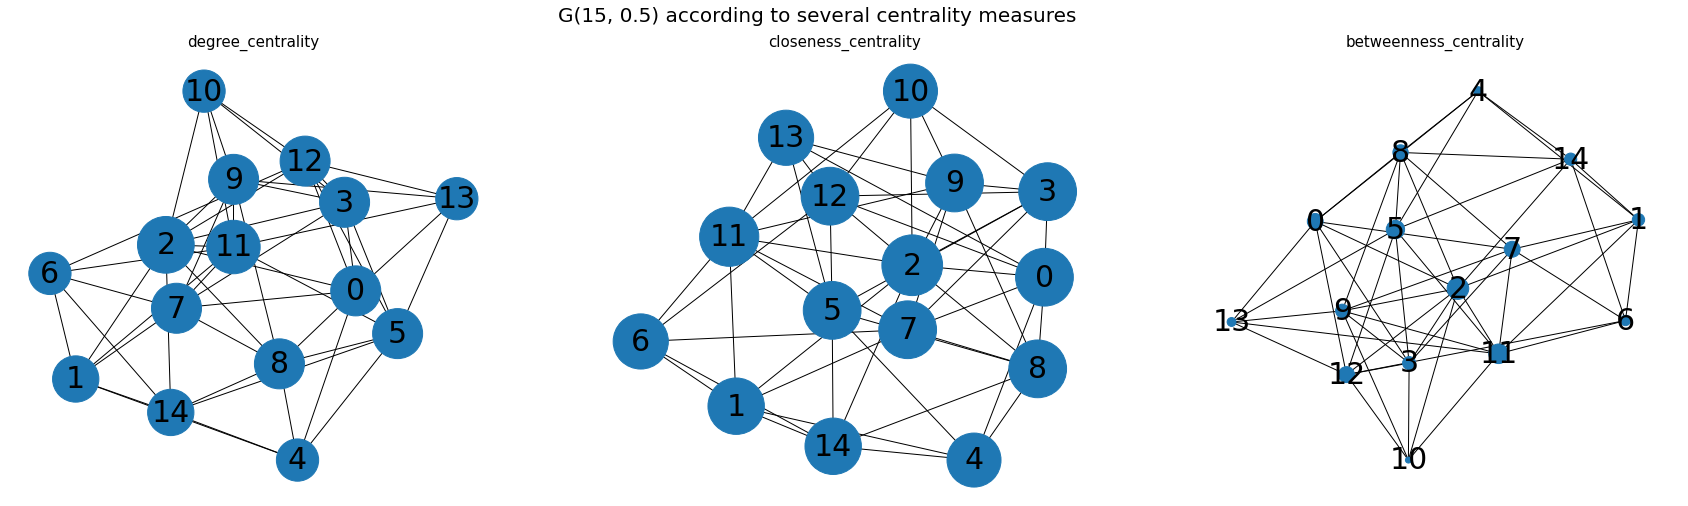

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle(f'G(15, 0.5) according to several centrality measures', fontsize=20)
fig.subplots_adjust(top=.9)

for i, measure in enumerate(measures.keys()):
    nx.draw(G, with_labels=True, font_size=30, node_size=[v*5000 for v in results[measure].to_list()], ax=ax[i])
    ax[i].set_title(measure, fontsize=15)
plt.show()

### D

Color red:
Degree Centrality: 0.5555555555555556
Closeness Centrality: 0.6923076923076923
Betweeness Centrality: 0.5555555555555556
Color green:
Degree Centrality: 0.5555555555555556
Closeness Centrality: 0.6923076923076923
Betweeness Centrality: 0.7222222222222222
Color gray:
Degree Centrality: 0.4444444444444444
Closeness Centrality: 0.5
Betweeness Centrality: 0.0
Color blue:
Degree Centrality: 0.1111111111111111
Closeness Centrality: 0.42857142857142855
Betweeness Centrality: 0.0


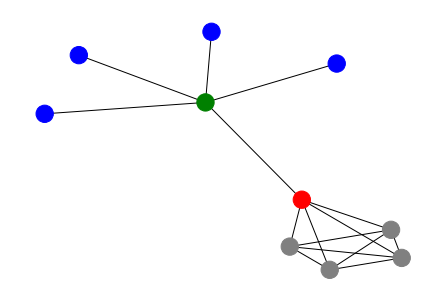

In [42]:
# Get ground truth to question 2D:
# ( WE SOLVED THE QUESTION ON THE PDF WITHOUT IT )

G = nx.empty_graph(10)

color_map = ["gray",  # 0
            "gray",   # 1
            "gray",   # 2
            "gray",   # 3
            "red",    # 4
            "green",  # 5
            "blue",   # 6
            "blue",   # 7
            "blue",   # 8
            "blue",   # 9
]

# connect all the grays as a clique
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(0, 3)
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(2, 3)

# connect all the grays to the red one
G.add_edge(4, 0)
G.add_edge(4, 1)
G.add_edge(4, 2)
G.add_edge(4, 3)

# connect the red and the green ones
G.add_edge(4,5)

# connect all the blues to the green one
G.add_edge(5, 6)
G.add_edge(5, 7)
G.add_edge(5, 8)
G.add_edge(5, 9)

for color, idx in [("red", 4), ("green", 5), ("gray", 0), ("blue", 9)]:
    print(f"Color {color}:")
    print(f"Degree Centrality: {nx.degree_centrality(G)[idx]}")
    print(f"Closeness Centrality: {nx.closeness_centrality(G)[idx]}")
    print(f"Betweeness Centrality: {nx.betweenness_centrality(G)[idx]}")


nx.draw(G, node_color=color_map)

# Question 3

In [43]:
# Install "unionfind" package. We used UF data structure/
!pip install unionfind
from unionfind import unionfind
from networkx.algorithms.bipartite import is_bipartite


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [44]:
def set_random_signs_to_edges(G, p):
    signs_dict = {edge:'+' if (p>np.random.rand(1)[0]) else '-' for edge in G.edges}
    nx.set_edge_attributes(G, signs_dict, "sign")
    return signs_dict, G

In [45]:
def check_balance(G):
    # Create an SCC graph using only '+' edges
    SCC = unionfind(G.number_of_nodes())
    for node1, node2 in G.edges:
        if G.edges[node1, node2]['sign'] == '+':
            SCC.unite(node1, node2)
    
    # If some SCC contains a '-' then the graph is unbalanced
    for node1, node2 in G.edges:
        if (G.edges[node1, node2]['sign'] == '-') & (SCC.issame(node1, node2)):
            return False
    
    # Two-way mapping between original nodes to their SCC
    SCC_to_graph_dict = {i:group for i, group in enumerate(SCC.groups())}
    graph_to_SCC_dict = {} 
    for new_node, group in SCC_to_graph_dict.items():
        for old_node in group:
            graph_to_SCC_dict[old_node] = new_node
    
    # Creating a nx graph representing the SCC graph with only '-' edges
    SCC_graph = nx.empty_graph(len(SCC.groups()))
    for new_node, SCC_group in SCC_to_graph_dict.items():
        for G_node, SCC_node in product(G.nodes, SCC_group):
            if (G_node not in SCC_group) and G.has_edge(G_node, SCC_node):
                if G.edges[G_node, SCC_node]['sign'] == '-':
                    SCC_graph.add_edge(new_node, graph_to_SCC_dict[G_node])
    
    return is_bipartite(SCC_graph)

In [46]:
def draw_graph_with_signs(G, signs_dict):
    # Seperating negative to positive edges
    positive_edges, negative_edges = [], []
    for edge, sign in signs_dict.items():
        if sign == '+':
            positive_edges.append(edge) 
        else:
            negative_edges.append(edge)
    
    # Plots
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='#F4E2DE')
    nx.draw_networkx_edges(G, pos, edgelist=positive_edges, width=2, edge_color='#44803F')
    nx.draw_networkx_edges(G, pos, edgelist=negative_edges, width=2, edge_color='#FF5A33')
    nx.draw_networkx_labels(G, pos, font_size=18, font_family='sans-serif')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=signs_dict)
    plt.axis('off')
    plt.show()

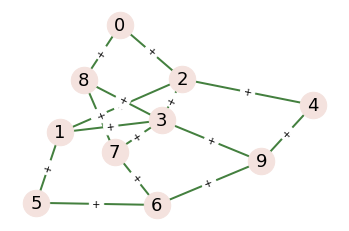

In [47]:
G = get_erdos_renyi_model(10, .4)
signs_dict, G = set_random_signs_to_edges(G, .95)
draw_graph_with_signs(G, signs_dict)

In [48]:
check_balance(G)

True

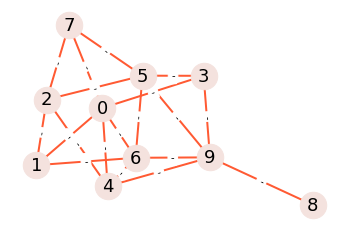

In [49]:
G = get_erdos_renyi_model(10, .4)
signs_dict, G = set_random_signs_to_edges(G, .05)
draw_graph_with_signs(G, signs_dict)

In [50]:
check_balance(G)

False